In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models, ops
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
epochs = 100
batch = 1024

In [2]:
root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
predictions_path = f"{root}/datasets/{dataset_name}_predictions.npz"
siamese_save_path = f"{root}/models/{dataset_name}_siamese.keras"
classifier_path = f"{root}/models/{dataset_name}_classifier.keras"

## MODELS
def distance(vects):
    """
    Computes the cosine distance between pairs of vectors.
    """
    x, y = vects[:,0], vects[:,1]
    x = ops.normalize(x, axis=1)
    y = ops.normalize(y, axis=1)
    return ops.sum(x * y, axis=1)

@keras.saving.register_keras_serializable()
def contrastive_Sig_loss(y_true, y_pred):
    z = (0.5 - y_true) * 2  # z = 1 per D+, z = -1 per D-
    dist = distance(y_pred)

    similarity = ops.negative(1.0 * dist) + 0.0
    denomiator = 1 + ops.exp(z * similarity)
    batch_loss = ops.log(1 / denomiator)
    return ops.negative(ops.mean(batch_loss))

classifier = models.load_model(classifier_path)
best_siamese = models.load_model(siamese_save_path)
correction = best_siamese.get_layer('correction')

In [3]:
## DATASET
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

## DATASET PREDICTIONS
predictions = np.load(predictions_path, allow_pickle=True)
y_train_pred = predictions['y_train_pred']
y_val_pred = predictions['y_val_pred']
y_test_pred = predictions['y_test_pred']

## DATASET MODIFICATION
x_train_modified = correction(x_train)
x_val_modified = correction(x_val)
x_test_modified = correction(x_test)

## BALANCE CLASSES
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)
total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}


In [4]:
## RE-TRAINING THE CLASSIFIER
classifier_new = keras.models.clone_model(classifier)
classifier_new.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [5]:
history = classifier_new.fit(
    x_train_modified, y_train,
    validation_data=(x_val_modified, y_val),
    epochs=epochs,
    batch_size=batch,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)
    ]
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.8711 - loss: 2.0717 - val_accuracy: 0.8884 - val_loss: 1.7978
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8926 - loss: 1.7326 - val_accuracy: 0.8881 - val_loss: 1.8031
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8929 - loss: 1.7282 - val_accuracy: 0.8881 - val_loss: 1.8022
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8926 - loss: 1.7321 - val_accuracy: 0.8879 - val_loss: 1.8042
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8927 - loss: 1.7313 - val_accuracy: 0.8883 - val_loss: 1.7985
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8929 - loss: 1.7275 - val_accuracy: 0.8876 - val_loss: 1.8117
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8928 - loss: 1.7289 - val_accuracy: 0.8881 - val_loss: 1.8014
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8930 - loss: 1.7254 - val_accuracy: 0.8877 

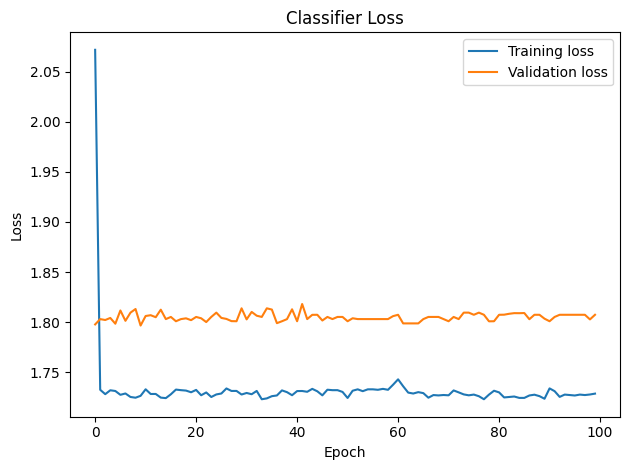

In [6]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


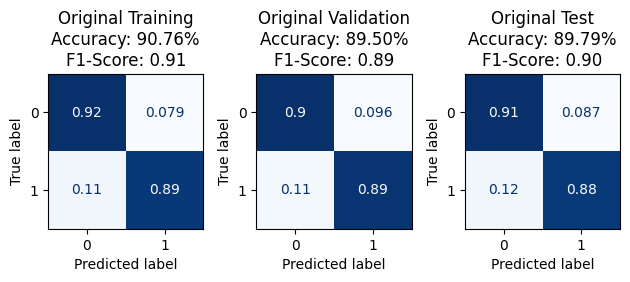

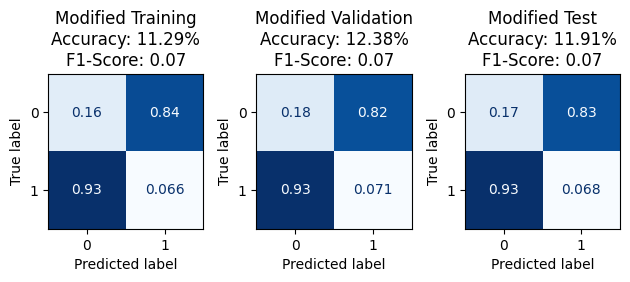

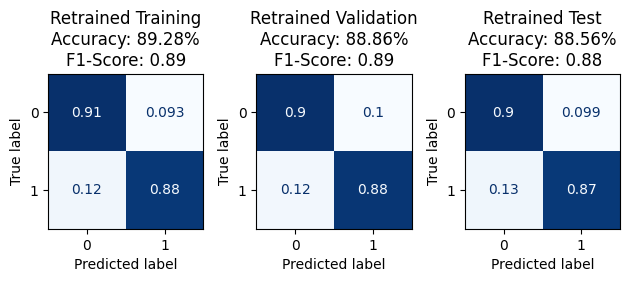

In [7]:
## EVALUATION OLD CLASSIFIER VS NEW CLASSIFIER
y_train_pred_mod = ops.argmax(classifier.predict(x_train_modified), axis=1)
y_val_pred_mod = ops.argmax(classifier.predict(x_val_modified), axis=1)
y_test_pred_mod = ops.argmax(classifier.predict(x_test_modified), axis=1)

y_train_pred_new = ops.argmax(classifier_new.predict(x_train_modified), axis=1)
y_val_pred_new = ops.argmax(classifier_new.predict(x_val_modified), axis=1)
y_test_pred_new = ops.argmax(classifier_new.predict(x_test_modified), axis=1)

titles_data = ["Training", "Validation", "Test"]
true_labels = [y_train, y_val, y_test]
data_to_evaluate = [
    ("Original", y_train_pred, y_val_pred, y_test_pred),
    ("Modified", y_train_pred_mod, y_val_pred_mod, y_test_pred_mod),
    ("Retrained", y_train_pred_new, y_val_pred_new, y_test_pred_new),
]

for (title, *all_predictions) in data_to_evaluate:
    list_data = zip(titles_data, true_labels, all_predictions)
    _, axes = plt.subplots(1, len(titles_data), figsize=None)

    for i, (title_data, yy_true, yy_pred) in enumerate(list_data):
        ConfusionMatrixDisplay.from_predictions(
            yy_true, yy_pred,
            normalize='true',
            display_labels=[i for i in range(total_classes)],
            cmap=plt.cm.Blues,
            colorbar=False,
            ax=axes[i]
        )
        axes[i].set_title(f"{title} {title_data}\n"
                            + f"Accuracy: {balanced_accuracy_score(yy_true, yy_pred):.2%}\n"
                            + f"F1-Score: {f1_score(yy_true, yy_pred):.2f}")
    plt.tight_layout()
    plt.show()
